ANALIZA MODELI ENSEMBLE - PORÓWNANIE I TUNING

CZĘŚĆ 1: DANE Z POPRZEDNIEGO ZADANIA (wariant 9)

Rozkład klas: {0: 255, 1: 245}
Proporcje: {0: 0.51, 1: 0.49}

--------------------------------------------------------------------------------
ZADANIE 1: Porównanie Random Forest, XGBoost i Stacking
--------------------------------------------------------------------------------

1. Random Forest:
   Accuracy: 0.9733

2. XGBoost:
   Accuracy: 0.9533

3. Stacking (RF + DecisionTree + LogReg):
   Accuracy: 0.9533

--------------------------------------------------------------------------------
ZADANIE 2: Tuning hiperparametrów XGBoost
--------------------------------------------------------------------------------

Siatka parametrów:
   n_estimators: [50, 100, 200]
   max_depth: [3, 5, 7]
   learning_rate: [0.01, 0.1, 0.3]
   subsample: [0.8, 1.0]

Przeprowadzanie manualnego grid search (może zająć chwilę)...
Testowanie 54 kombinacji parametrów...

Najlepsze parametry:
   n_estimators: 50
   

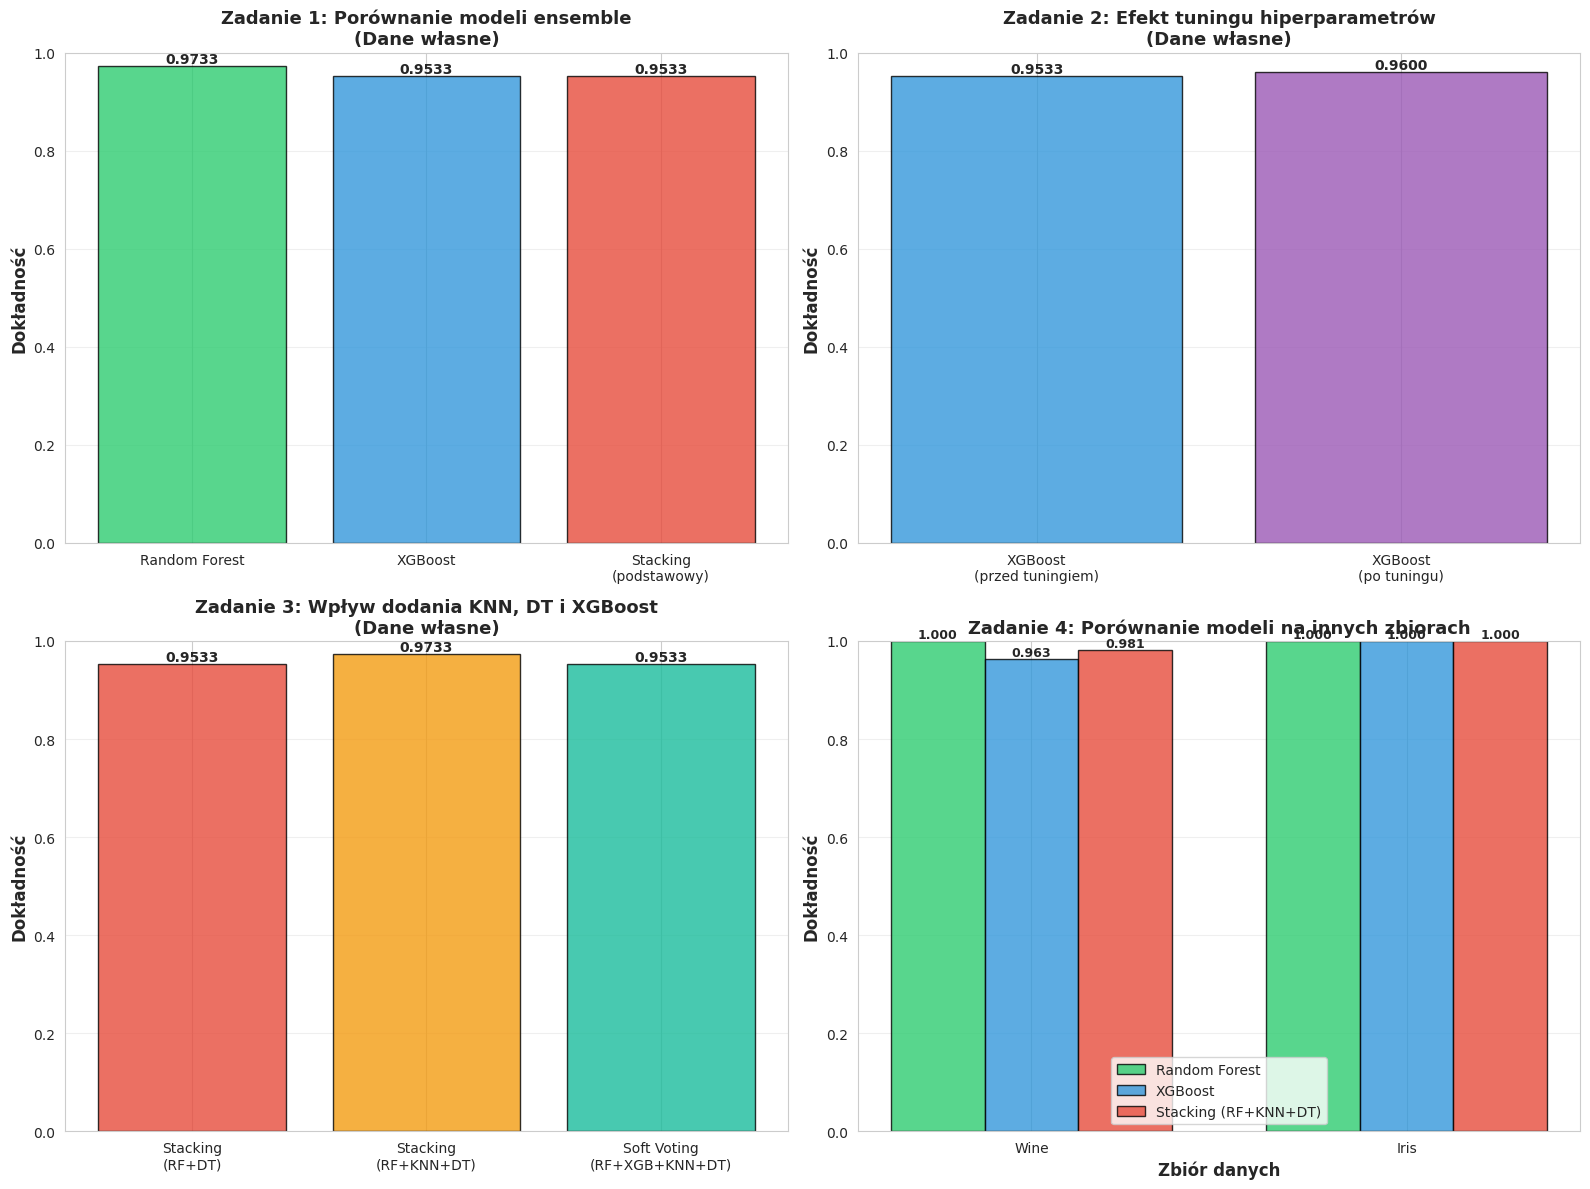


PODSUMOWANIE KOŃCOWE

Dane własne (wariant 9):
                 Model  Accuracy
         Random Forest  0.973333
       XGBoost (przed)  0.953333
          XGBoost (po)  0.960000
      Stacking (RF+DT)  0.953333
  Stacking (RF+KNN+DT)  0.973333
Voting (RF+XGB+KNN+DT)  0.953333


Inne zbiory danych:

Wine:
   Random Forest: 1.0000
   XGBoost: 0.9630
   Stacking (RF+KNN+DT): 0.9815

Iris:
   Random Forest: 1.0000
   XGBoost: 1.0000
   Stacking (RF+KNN+DT): 1.0000


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.datasets import load_wine, load_iris
from xgboost import XGBClassifier
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

np.random.seed(42)
X = np.random.randn(500, 2) * [3, 1]
y = (X[:, 0] > X[:, 1]).astype(int)

print(f"\nRozkład klas: {pd.Series(y).value_counts().to_dict()}")
print(f"Proporcje: {pd.Series(y).value_counts(normalize=True).to_dict()}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#PORÓWNANIE MODELI

print("\n" + "-"*80)
print("Porównanie Random Forest, XGBoost i Stacking")
print("-"*80)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print("\n1. Random Forest:")
print(f"   Accuracy: {rf_accuracy:.4f}")

# XGBoost
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)

print("\n2. XGBoost:")
print(f"   Accuracy: {xgb_accuracy:.4f}")

# Stacking (podstawowy)
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
]
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)
stacking_model.fit(X_train, y_train)
stacking_pred = stacking_model.predict(X_test)
stacking_accuracy = accuracy_score(y_test, stacking_pred)

print("\n3. Stacking (RF + DecisionTree + LogReg):")
print(f"   Accuracy: {stacking_accuracy:.4f}")


#TUNING HIPERPARAMETRÓW XGBoost

print("\n" + "-"*80)
print("Tuning hiperparametrów XGBoost")
print("-"*80)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

print("\nSiatka parametrów:")
for param, values in param_grid.items():
    print(f"   {param}: {values}")

print("\nPrzeprowadzanie manualnego grid search (może zająć chwilę)...")

from itertools import product

best_score = 0
best_params = {}

param_combinations = list(product(
    param_grid['n_estimators'],
    param_grid['max_depth'],
    param_grid['learning_rate'],
    param_grid['subsample']
))

print(f"Testowanie {len(param_combinations)} kombinacji parametrów...")

for n_est, max_d, lr, subs in param_combinations:
    model = XGBClassifier(
        n_estimators=n_est,
        max_depth=max_d,
        learning_rate=lr,
        subsample=subs,
        random_state=42,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)
    score = accuracy_score(y_test, model.predict(X_test))
    
    if score > best_score:
        best_score = score
        best_params = {
            'n_estimators': n_est,
            'max_depth': max_d,
            'learning_rate': lr,
            'subsample': subs
        }

print("\nNajlepsze parametry:")
for param, value in best_params.items():
    print(f"   {param}: {value}")

xgb_tuned = XGBClassifier(**best_params, random_state=42, eval_metric='logloss')
xgb_tuned.fit(X_train, y_train)
xgb_tuned_pred = xgb_tuned.predict(X_test)
xgb_tuned_accuracy = accuracy_score(y_test, xgb_tuned_pred)

print(f"\nXGBoost (przed tuningiem): {xgb_accuracy:.4f}")
print(f"XGBoost (po tuningu):      {xgb_tuned_accuracy:.4f}")
print(f"Poprawa: {(xgb_tuned_accuracy - xgb_accuracy)*100:.2f}%")


# ROZSZERZONY STACKING Z KNN I DecisionTree

print("\n" + "-"*80)
print("Rozszerzony Stacking z dodatkowymi modelami")
print("-"*80)

# Stacking
extended_base_learners = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42))
]

stacking_extended = StackingClassifier(
    estimators=extended_base_learners,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)
stacking_extended.fit(X_train, y_train)
stacking_extended_pred = stacking_extended.predict(X_test)
stacking_extended_accuracy = accuracy_score(y_test, stacking_extended_pred)


print("\nMetoda alternatywna: Soft Voting z XGBoost")
print("(ze względu na problemy z kompatybilnością XGBoost w StackingClassifier)")

models_for_voting = {
    'RF': RandomForestClassifier(n_estimators=50, random_state=42),
    'XGB': XGBClassifier(n_estimators=50, random_state=42, eval_metric='logloss'),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'DT': DecisionTreeClassifier(max_depth=5, random_state=42)
}

predictions = []
for name, model in models_for_voting.items():
    model.fit(X_train, y_train)
    pred_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    if pred_proba is not None:
        predictions.append(pred_proba)

# Soft voting 
avg_predictions = np.mean(predictions, axis=0)
voting_pred = np.argmax(avg_predictions, axis=1)
voting_accuracy = accuracy_score(y_test, voting_pred)

print("\nModele bazowe w Stackingu (bez XGBoost):")
for name, _ in extended_base_learners:
    print(f"   - {name}")
print(f"   - Meta-model: LogisticRegression")

print(f"\nModele w Soft Voting (z XGBoost):")
for name in models_for_voting.keys():
    print(f"   - {name}")

print(f"\nStacking (podstawowy RF+DT):         {stacking_accuracy:.4f}")
print(f"Stacking (rozszerzony RF+KNN+DT):    {stacking_extended_accuracy:.4f}")
print(f"Soft Voting (RF+XGB+KNN+DT):         {voting_accuracy:.4f}")


#TEST NA INNYCH ZBIORACH DANYCH
print("\n" + "="*80)
print("Test modeli na innych zbiorach danych")
print("="*80)

datasets = {
    'Wine': load_wine(),
    'Iris': load_iris()
}

results_other_datasets = {}

for dataset_name, dataset in datasets.items():
    print(f"\n{'-'*80}")
    print(f"Dataset: {dataset_name}")
    print(f"{'-'*80}")
    
    X_data = dataset.data
    y_data = dataset.target
    
    print(f"Rozmiar: {X_data.shape}")
    print(f"Liczba klas: {len(np.unique(y_data))}")
    
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_data, y_data, test_size=0.3, random_state=42
    )
    
    models_to_test = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
        'Stacking (RF+KNN+DT)': StackingClassifier(
            estimators=[
                ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
                ('knn', KNeighborsClassifier(n_neighbors=5)),
                ('dt', DecisionTreeClassifier(max_depth=5, random_state=42))
            ],
            final_estimator=LogisticRegression(max_iter=1000),
            cv=5
        )
    }
    
    dataset_results = {}
    for model_name, model in models_to_test.items():
        model.fit(X_tr, y_tr)
        pred = model.predict(X_te)
        acc = accuracy_score(y_te, pred)
        dataset_results[model_name] = acc
        print(f"   {model_name}: {acc:.4f}")
    
    results_other_datasets[dataset_name] = dataset_results

# WYKRESY PORÓWNAWCZE

print("\n" + "="*80)
print(" Wizualizacja wyników")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
models_basic = ['Random Forest', 'XGBoost', 'Stacking\n(podstawowy)']
accuracies_basic = [rf_accuracy, xgb_accuracy, stacking_accuracy]
colors_basic = ['#2ecc71', '#3498db', '#e74c3c']

bars1 = ax1.bar(models_basic, accuracies_basic, color=colors_basic, alpha=0.8, edgecolor='black')
ax1.set_ylabel('Dokładność', fontsize=12, fontweight='bold')
ax1.set_title('Zadanie 1: Porównanie modeli ensemble\n(Dane własne)', 
              fontsize=13, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontweight='bold')

ax2 = axes[0, 1]
xgb_comparison = ['XGBoost\n(przed tuningiem)', 'XGBoost\n(po tuningu)']
xgb_accs = [xgb_accuracy, xgb_tuned_accuracy]
colors_xgb = ['#3498db', '#9b59b6']

bars2 = ax2.bar(xgb_comparison, xgb_accs, color=colors_xgb, alpha=0.8, edgecolor='black')
ax2.set_ylabel('Dokładność', fontsize=12, fontweight='bold')
ax2.set_title('Zadanie 2: Efekt tuningu hiperparametrów\n(Dane własne)', 
              fontsize=13, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontweight='bold')

ax3 = axes[1, 0]
stacking_comparison = ['Stacking\n(RF+DT)', 'Stacking\n(RF+KNN+DT)', 'Soft Voting\n(RF+XGB+KNN+DT)']
stacking_accs = [stacking_accuracy, stacking_extended_accuracy, voting_accuracy]
colors_stack = ['#e74c3c', '#f39c12', '#1abc9c']

bars3 = ax3.bar(stacking_comparison, stacking_accs, color=colors_stack, 
                alpha=0.8, edgecolor='black')
ax3.set_ylabel('Dokładność', fontsize=12, fontweight='bold')
ax3.set_title('Zadanie 3: Wpływ dodania KNN, DT i XGBoost\n(Dane własne)', 
              fontsize=13, fontweight='bold')
ax3.set_ylim([0, 1])
ax3.grid(axis='y', alpha=0.3)

for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontweight='bold')

ax4 = axes[1, 1]
x = np.arange(len(results_other_datasets))
width = 0.25

rf_scores = [results_other_datasets[ds]['Random Forest'] for ds in results_other_datasets]
xgb_scores = [results_other_datasets[ds]['XGBoost'] for ds in results_other_datasets]
stack_scores = [results_other_datasets[ds]['Stacking (RF+KNN+DT)'] for ds in results_other_datasets]

bars4_1 = ax4.bar(x - width, rf_scores, width, label='Random Forest', 
                  color='#2ecc71', alpha=0.8, edgecolor='black')
bars4_2 = ax4.bar(x, xgb_scores, width, label='XGBoost', 
                  color='#3498db', alpha=0.8, edgecolor='black')
bars4_3 = ax4.bar(x + width, stack_scores, width, label='Stacking (RF+KNN+DT)', 
                  color='#e74c3c', alpha=0.8, edgecolor='black')

ax4.set_ylabel('Dokładność', fontsize=12, fontweight='bold')
ax4.set_xlabel('Zbiór danych', fontsize=12, fontweight='bold')
ax4.set_title('Zadanie 4: Porównanie modeli na innych zbiorach', 
              fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(list(results_other_datasets.keys()))
ax4.legend(fontsize=10)
ax4.set_ylim([0, 1])
ax4.grid(axis='y', alpha=0.3)

for bars in [bars4_1, bars4_2, bars4_3]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}',
                 ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('ensemble_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# PODSUMOWANIE WSZYSTKICH WYNIKÓW

print("\n" + "="*80)
print("PODSUMOWANIE KOŃCOWE")
print("="*80)

print("\nDane własne (wariant 9):")
summary_own = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost (przed)', 'XGBoost (po)', 
              'Stacking (RF+DT)', 'Stacking (RF+KNN+DT)', 'Voting (RF+XGB+KNN+DT)'],
    'Accuracy': [rf_accuracy, xgb_accuracy, xgb_tuned_accuracy, 
                 stacking_accuracy, stacking_extended_accuracy, voting_accuracy]
})
print(summary_own.to_string(index=False))

print("\n\nInne zbiory danych:")
for dataset_name, results in results_other_datasets.items():
    print(f"\n{dataset_name}:")
    for model, acc in results.items():
        print(f"   {model}: {acc:.4f}")



In [3]:
%pip install seaborn